# Regression Project

-

## 주제 :  

## 계절성을 고려한 제주도 전력 예측

# 작업 환경 설정

In [5]:
import matplotlib.dates as md
import pandas as pd
import numpy as np
import math
import datetime
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from matplotlib import rc
from patsy import *
plt.style.use('seaborn')
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

-



## 배경 : 

1. 전력수요 예측은 전력 공급정책의 기초자료중 하나. 
전력수요 예측은 에너지 분야 최상위 행정계획인 에너지기본계획에 영향을 미침.

관련기사 \
http://www.headlinejeju.co.kr/news/articleView.html?idxno=417262 \
"제주도 6차 지역에너지계획, 전력설비, 풍력발전 공급과잉" - 2020년 5월 기사 

2. 제주도 전력수요 예측의 실패 현황

관련 기사 \
http://www.jejusori.net/news/articleView.html?idxno=132579 \
"올 여름 제주지역 최대 전력수요 예측량도 빗나갔다" -2013년 기사 \
http://www.jejusori.net/news/articleView.html?idxno=209324 \
"제주 최대 전력수요 빗나가.. 10% 증가 법칙도 깨져"
"101만 5000kW 까지 치솟을 것으로 전망했지만, 6만 6000kW를 밑돌아" - 2018년 8월 기사 


3. 제주도 관광객 유입에 따른 전력수요 증가

관련기사 \
http://www.headlinejeju.co.kr/news/articleView.html?idxno=369648 \
"여름 휴가시즌을 맞아 제주관광이 최성수기를 맞아 전력이 풀가동.." - 2019년 8월 기사 


-

## 데이터 
1. 기상/전력 데이터 https://dacon.io/competitions/official/235606/overview/ (데이콘)

2. 관광객 데이터 http://www.visitjeju.or.kr/web/bbs/bbsList.do?bbsId=TOURSTAT (제주도 관광협회)

3. 제주도 인구 데이터 https://www.jeju.go.kr/open/stats/news/trend.htm?act=view&seq=1162310&page=9 (제주도청)

4. 불쾌지수 데이터 (계산식 활용, 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3)

5. 체감온도 - 위키백과
수집 기간 : 2018.02.01 ~ 2020.05.18


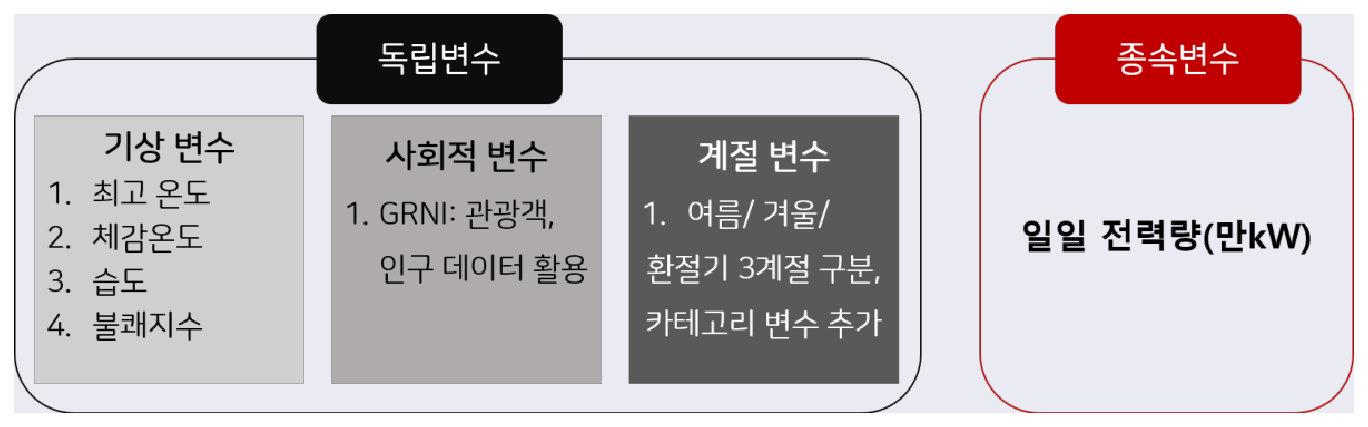

In [6]:
plt.figure(figsize =(12, 8))

img = mpimg.imread('feature.png')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(img)

## 변수 :

1. 독립변수 
    - 최고온도 (max_temp, celcius)
    - 체감온도 (body_temp, celcius)
    - 습도 (humid, %)
    - 불쾌지수 (angry, d.index) 
    - 지역총소득 :GRNI (tour/population ,명)
   

2. 종속변수 
    - 전력공급량 (supply, 만kW)

-

### 기존 선행 연구(제주 전력 예측)

김기수, 류구현, 송경빈 /온도특성에 대한 데이터 정제를 이용한 제주도의 단기 전력수요예측 대한전기학회전기학회논문지 (2009.09) 1,695 - 1,699

구본희, 윤경하, 차준민 /기온특성을 고려한 제주지역 전력 수요 예측(7,8월). 대한전기학회 학술대회 논문집 (2011.10) 250-253 

구본희, 차준민 / 기온변화특성을 이용한 제주계통 하절기 전력수요예측 대한전기학회대한전기학회 학술대회 논문집 (2012.05) 305 - 307

김혜민, 김인겸, 이대근 외 2/ 기온변수를 이용한 제주지역의 전력수요함수 추정 명한국혁신학회한국혁신학회지13(2) 2018.05 105 - 120 (16 pages)

-

## 문제 정의 : 

# 기존 제주 전력 예측은 온도를 이용한 하절기 예측 이다.

## 자료 정리(데이콘)

In [7]:
#제주도 날씨 데이터

In [8]:
pd.read_csv("weather_v2.csv").tail(3)

,area,datetime,temp,temp_QCFlag,prec,prec_QCFlag,ws,ws_QCFlag,wd,wd_QCFlag,...,vis,sfctype,weathernumber,sfctemp,sfctemp_QCFlag,landtemp_5cm,landtemp_10cm,landtemp_20cm,landtemp_30cm,station
746827,893,2020-05-18 21:00,15.1,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AWS
746828,893,2020-05-18 22:00,14.6,NaN,0.0,NaN,0.2,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AWS
746829,893,2020-05-18 23:00,13.6,NaN,0.0,NaN,1.2,NaN,221.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AWS


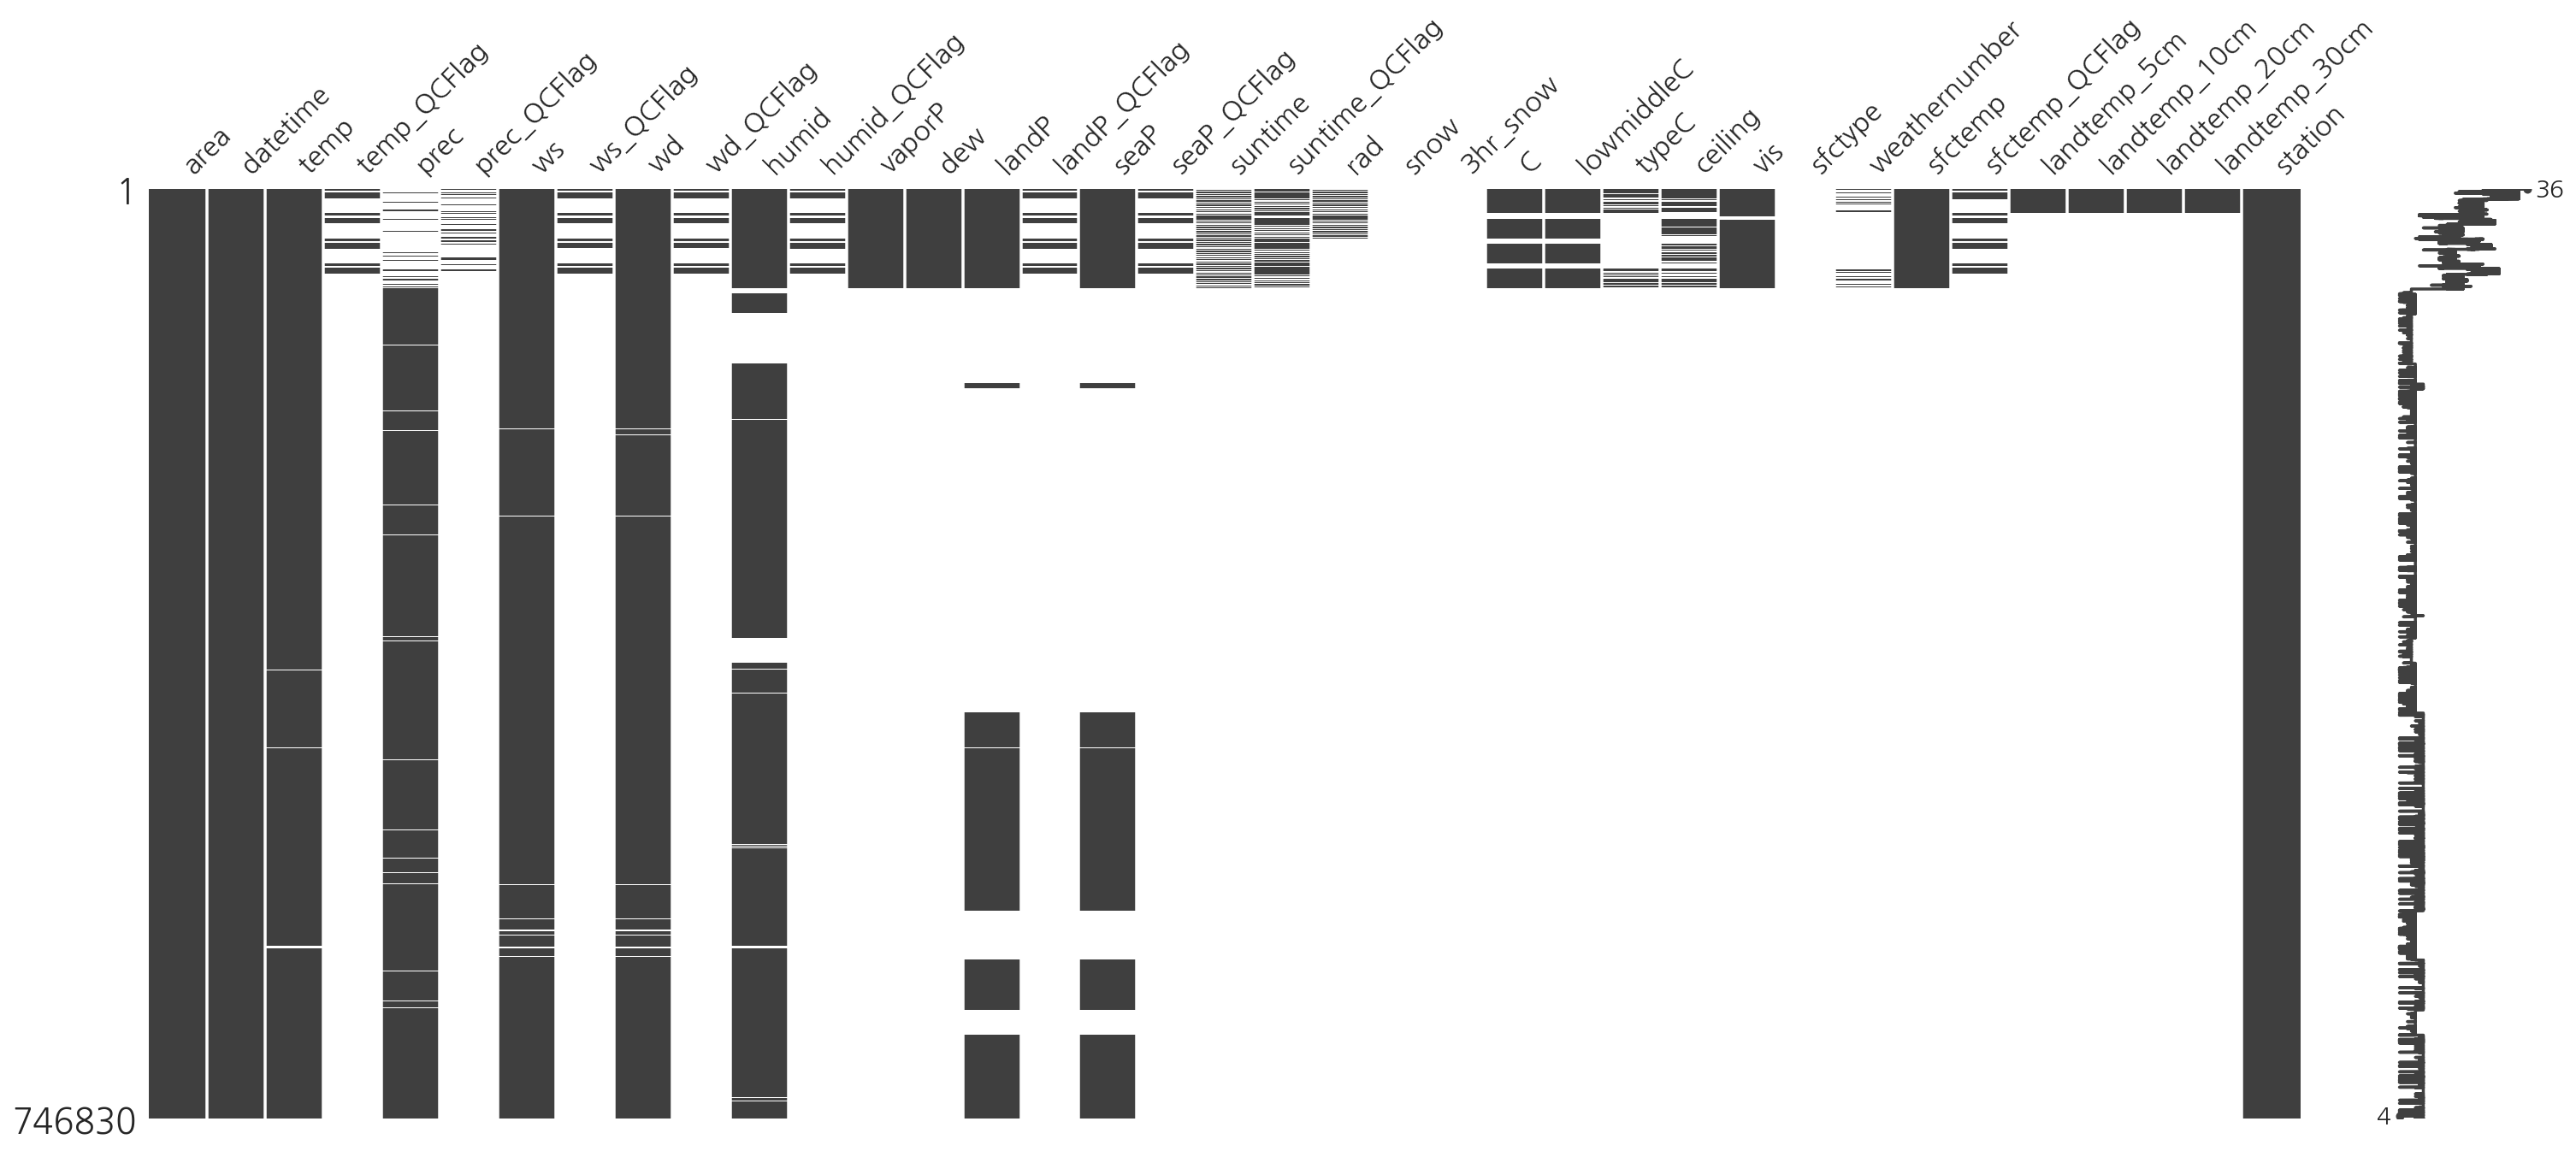

In [9]:
msno.matrix(pd.read_csv("weather_v2.csv"))
plt.show()

In [10]:
#제주도 전력량 ,smp 데이터

In [11]:
pd.read_csv("target_v2.csv").tail()

,date,smp_max,smp_min,smp_mean,supply
833,2020-05-14,193.28,66.78,100.46,62.70
834,2020-05-15,198.23,61.81,102.38,64.91
835,2020-05-16,220.91,88.50,121.19,61.75
836,2020-05-17,207.75,65.78,116.82,61.55
837,2020-05-18,113.31,66.86,98.98,63.91


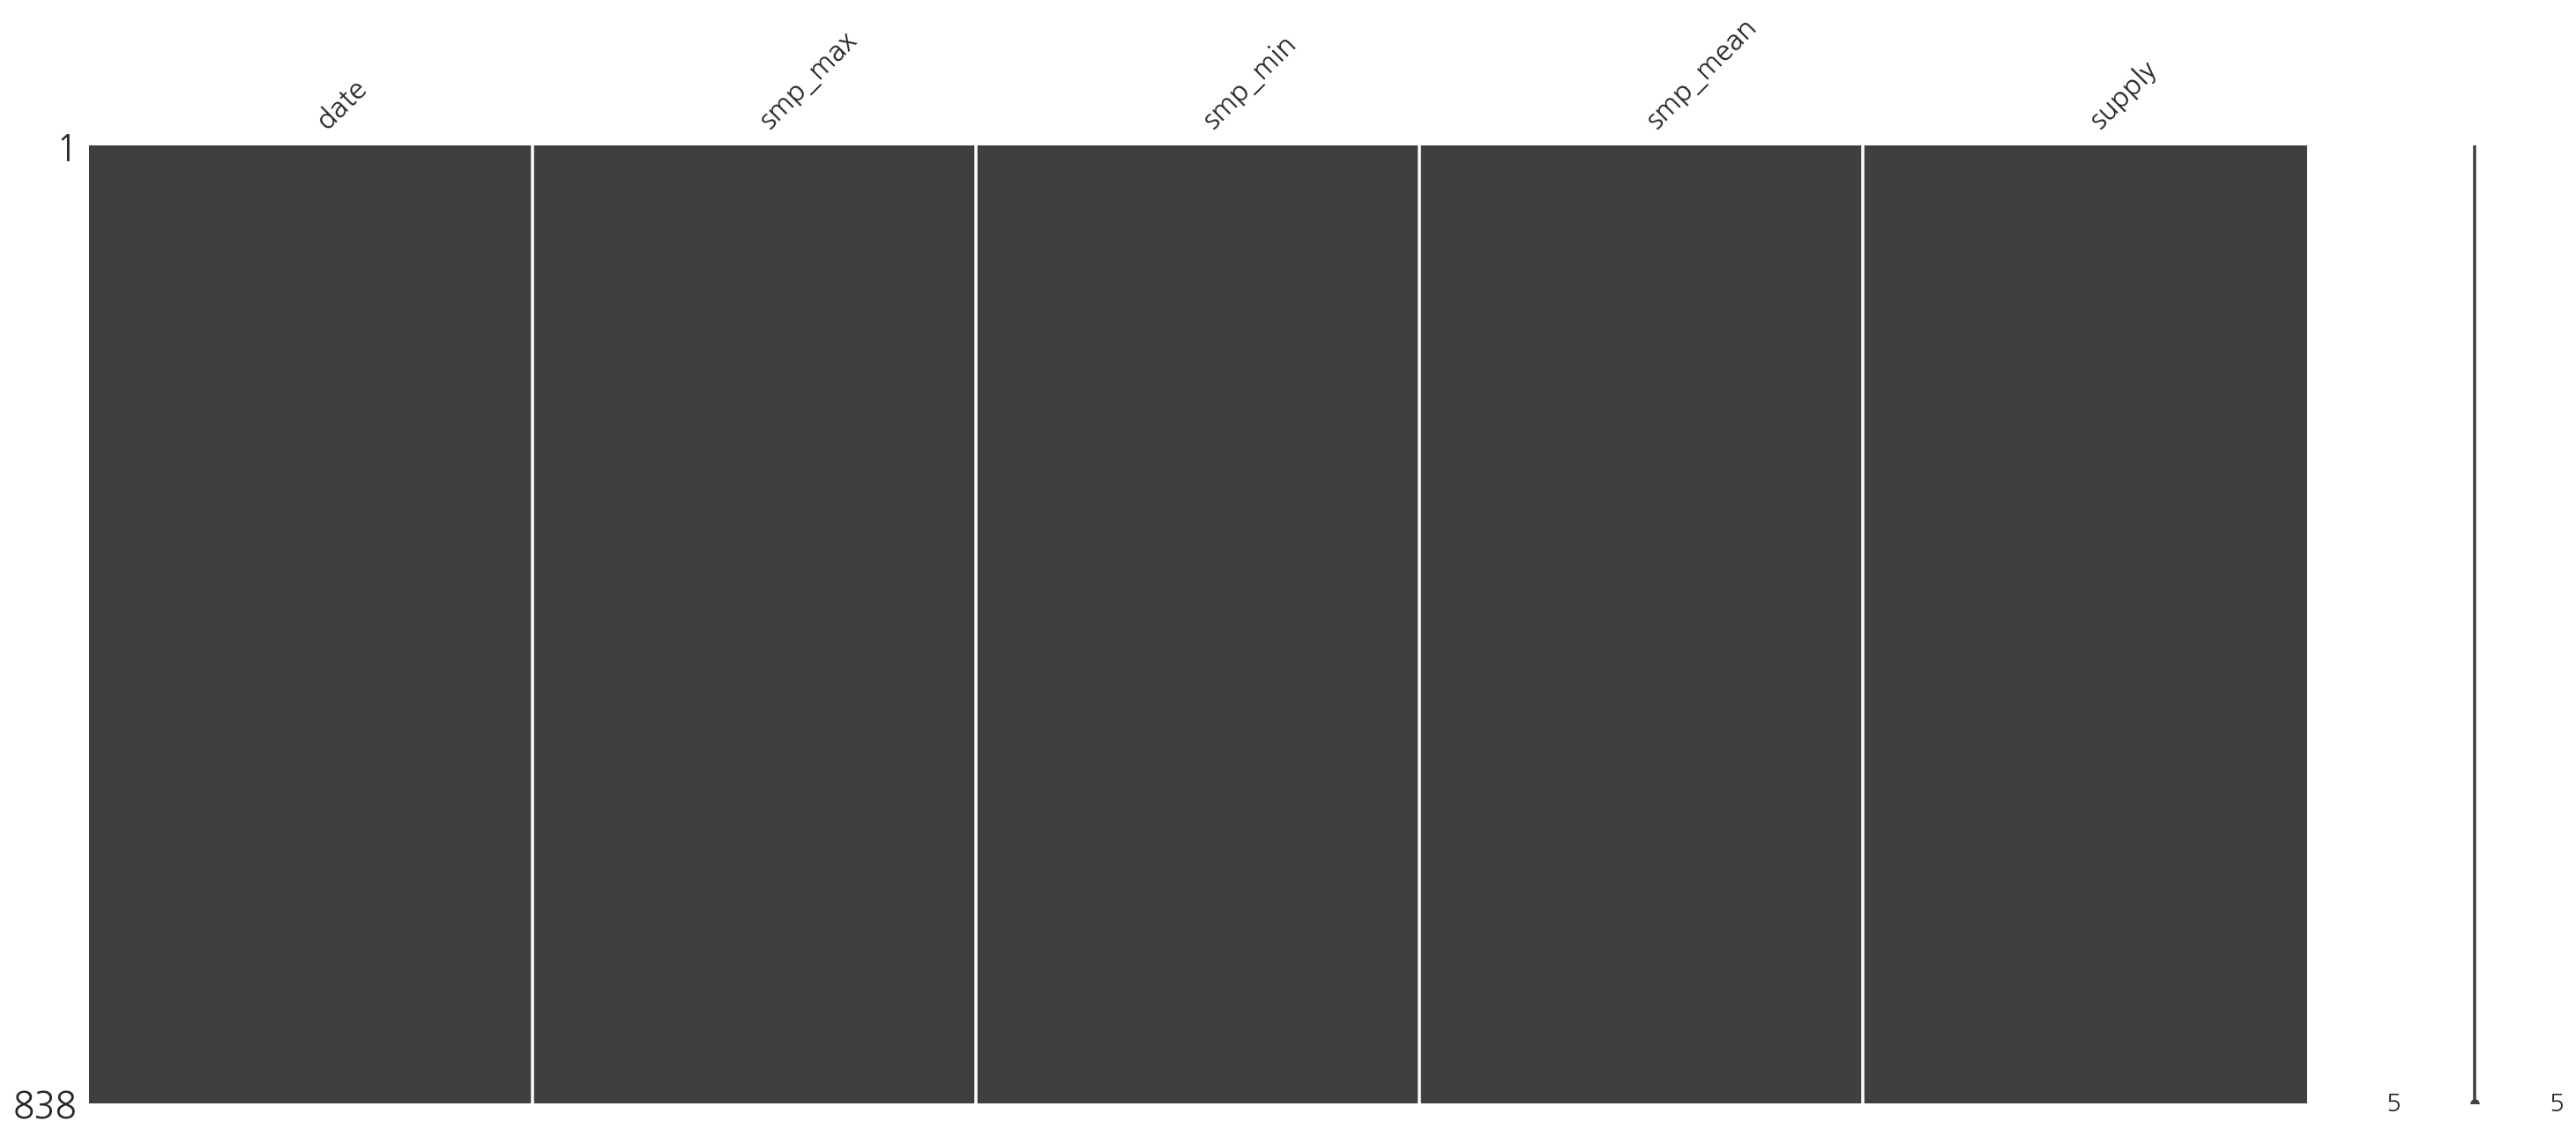

In [12]:
msno.matrix(pd.read_csv("target_v2.csv"))
plt.show()

# 제주도 기상청 데이터!

#### 1) ASOS 관측소의 데이터만 사용
- 전국적으로 ASOS가 관측한 기온이 공식으로 인정받고, AWS상의 기온은 참고용으로 사용
- 참고자료: https://www.yna.co.kr/view/AKR20180723154300004
- area: 184(제주), 185(고산), 188(성산), 189(서귀포)




In [13]:
#1
weather_df = pd.read_csv("weather_v2.csv")
weather_df = weather_df[weather_df["station"] == "ASOS"]
weather_df.tail(3)

,area,datetime,temp,temp_QCFlag,prec,prec_QCFlag,ws,ws_QCFlag,wd,wd_QCFlag,...,vis,sfctype,weathernumber,sfctemp,sfctemp_QCFlag,landtemp_5cm,landtemp_10cm,landtemp_20cm,landtemp_30cm,station
80429,189,2020-05-18 21:00,18.9,NaN,NaN,9.0,0.9,NaN,250.0,NaN,...,628.0,NaN,19.0,18.5,NaN,NaN,NaN,NaN,NaN,ASOS
80430,189,2020-05-18 22:00,18.1,NaN,NaN,9.0,2.4,NaN,20.0,NaN,...,1870.0,NaN,19.0,16.8,NaN,NaN,NaN,NaN,NaN,ASOS
80431,189,2020-05-18 23:00,17.7,NaN,NaN,9.0,0.9,NaN,290.0,NaN,...,2000.0,NaN,NaN,13.3,NaN,NaN,NaN,NaN,NaN,ASOS


#### 2) 시간 해상도 맞추기
- 전력량 데이터는 일 단위 , 기상청 데이터는 시간단위로 맞춰져 있어서 일일 단위로 통일하기로 

In [14]:
#2
def split_date(data, col):
    date = data[col].str.split(' ').str[0]
    time = data[col].str.split(' ').str[1]
    return date, time
weather_df["date"], weather_df["time"] = split_date(weather_df, "datetime")
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.tail(3)

,area,datetime,temp,temp_QCFlag,prec,prec_QCFlag,ws,ws_QCFlag,wd,wd_QCFlag,...,weathernumber,sfctemp,sfctemp_QCFlag,landtemp_5cm,landtemp_10cm,landtemp_20cm,landtemp_30cm,station,date,time
80429,189,2020-05-18 21:00,18.9,NaN,NaN,9.0,0.9,NaN,250.0,NaN,...,19.0,18.5,NaN,NaN,NaN,NaN,NaN,ASOS,2020-05-18,21:00
80430,189,2020-05-18 22:00,18.1,NaN,NaN,9.0,2.4,NaN,20.0,NaN,...,19.0,16.8,NaN,NaN,NaN,NaN,NaN,ASOS,2020-05-18,22:00
80431,189,2020-05-18 23:00,17.7,NaN,NaN,9.0,0.9,NaN,290.0,NaN,...,NaN,13.3,NaN,NaN,NaN,NaN,NaN,ASOS,2020-05-18,23:00


#### 3) 날씨 데이터의 36개의 독립변수 중 사용할 독립변수만 추출
- 온도, 풍속 사용

<Figure size 360x360 with 0 Axes>

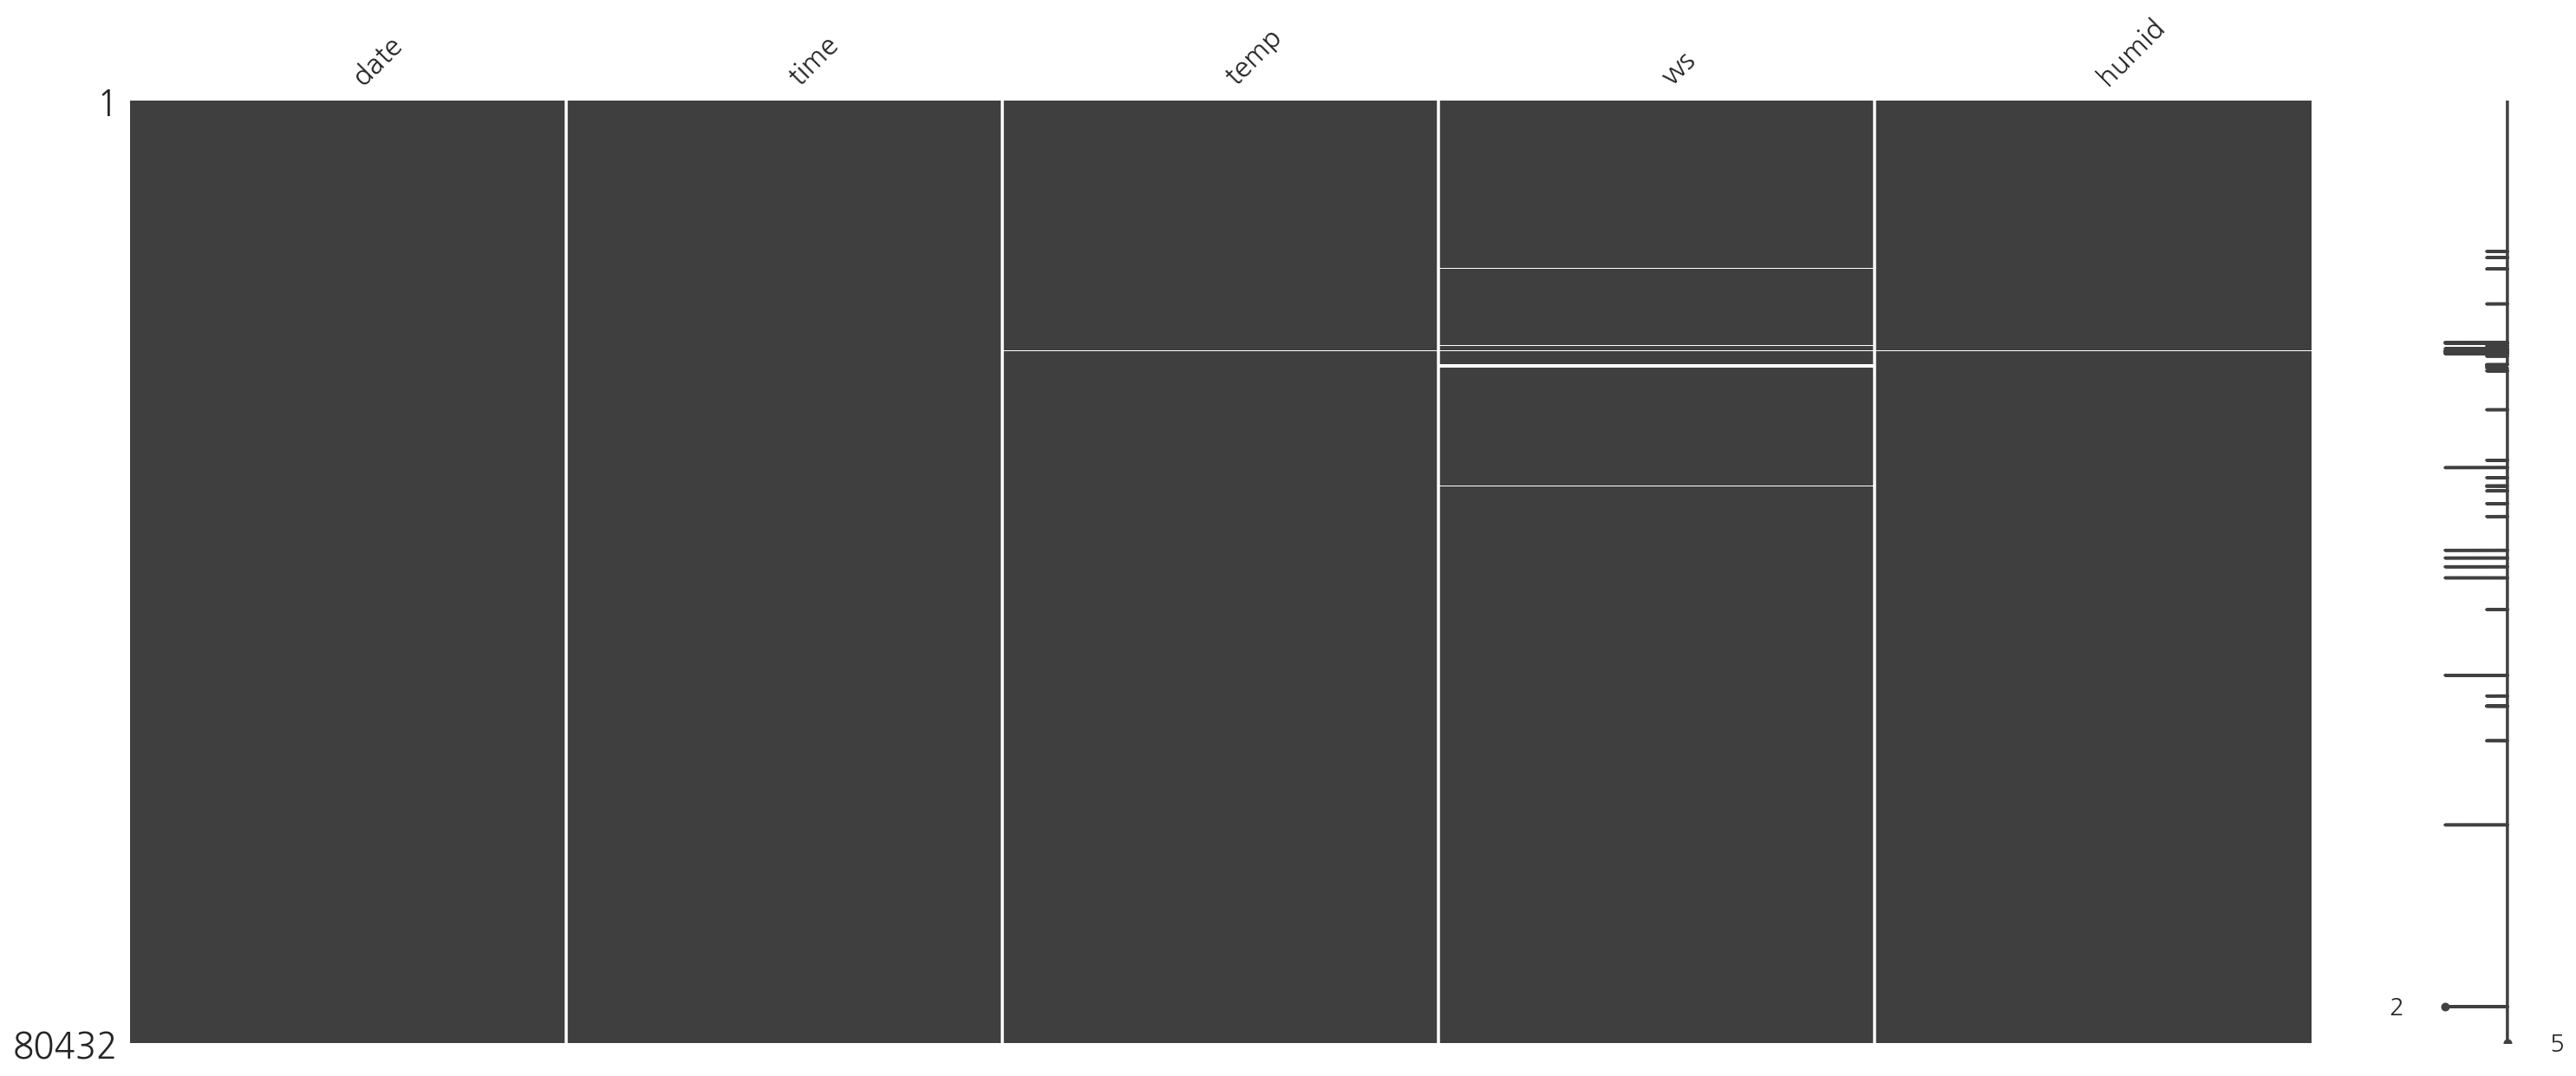

In [15]:
#3

plt.figure(figsize =(5, 5))
weather_useful = weather_df[["date", "time", "temp", "ws", "humid"]]
msno.matrix(weather_useful)
plt.show()


#### 4) 결측값 채우기
- 온도 데이터의 특성을 고려해서 선형으로 결측값 채움

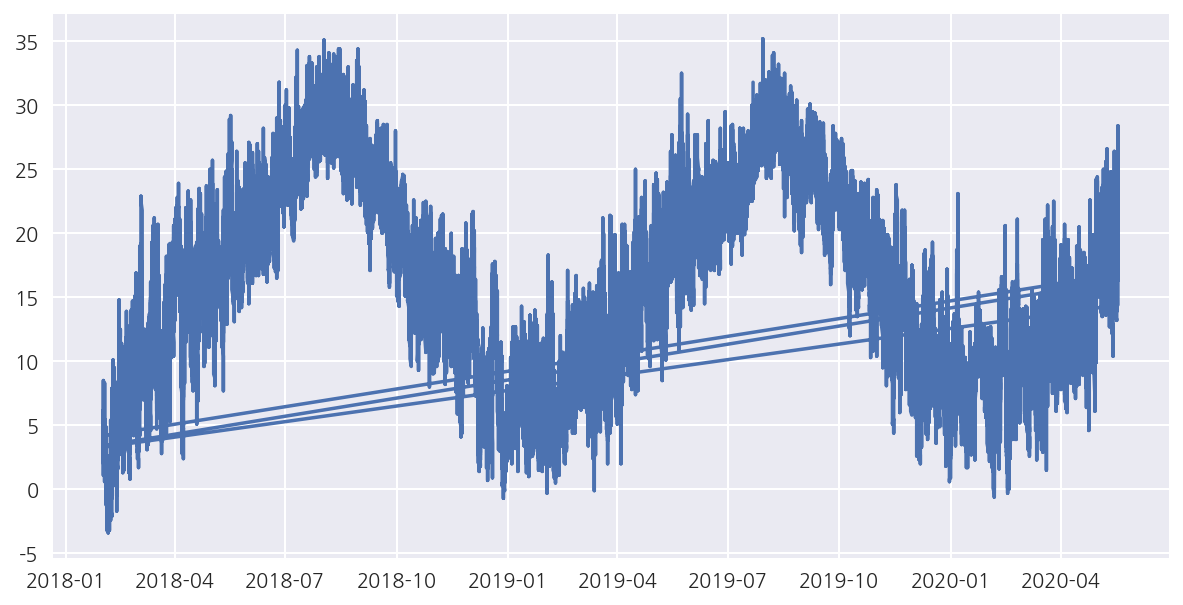

In [16]:
plt.figure(figsize =(10, 5))
plt.plot(weather_useful["date"],weather_useful["temp"])

In [17]:
#4
weather_full = weather_useful.interpolate(method='values') 
weather_full.isnull().sum()

date     0
time     0
temp     0
ws       0
humid    0
dtype: int64

#### 5) 습도 단위 변환
- 퍼센트로 변환

In [18]:
#5
weather_full["humid"] = weather_full["humid"] / 100

-

### 제주도 전력량 데이터 !

#### 1) 전력량 데이터 불러오기 
- 자료형 datetime 변환
- date, supply 값만 가져오기


In [19]:
#1
target = pd.read_csv("target_v2.csv")
# target의 날짜 데이터의 자료형을 str -> datetime으로 변환
target['date'] = pd.to_datetime(target['date'])
target = target[['date','supply']]
target.tail()

,date,supply
833,2020-05-14,62.70
834,2020-05-15,64.91
835,2020-05-16,61.75
836,2020-05-17,61.55
837,2020-05-18,63.91


#### 2) 날짜를 기준으로 날씨, 관광객, 인구수, 타겟 데이터프레임 병합

In [20]:
#2
target_v2 = target.merge(weather_full)
target_v2.tail()

,date,supply,time,temp,ws,humid
80427,2020-05-18,63.91,19:00,19.0,1.3,0.99
80428,2020-05-18,63.91,20:00,19.8,1.3,0.99
80429,2020-05-18,63.91,21:00,18.9,0.9,0.99
80430,2020-05-18,63.91,22:00,18.1,2.4,0.99
80431,2020-05-18,63.91,23:00,17.7,0.9,0.99


### 데이콘 데이터 자료 

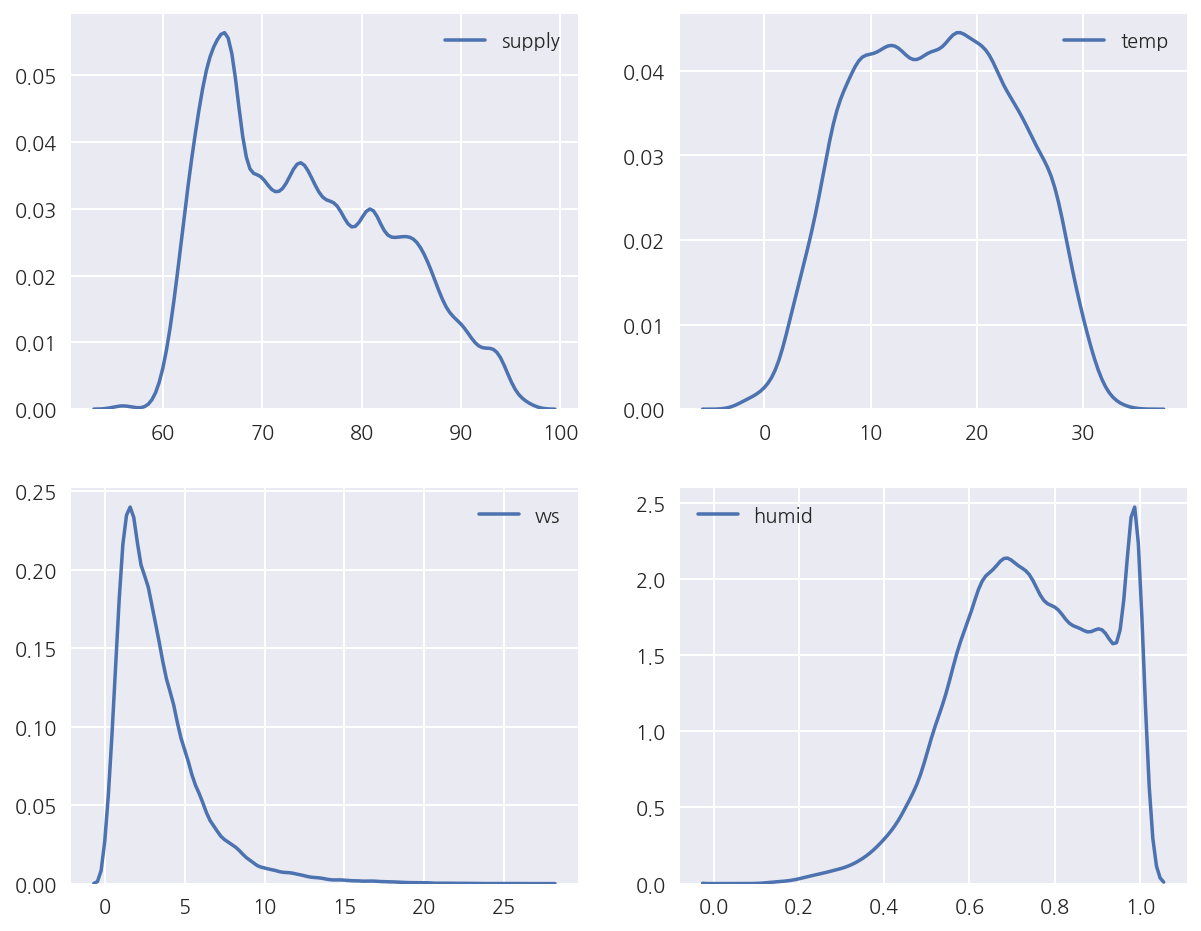

In [21]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
sns.kdeplot(target_v2['supply'])

plt.subplot(2,2,2)
sns.kdeplot(target_v2['temp'])

plt.subplot(2,2,3)
sns.kdeplot(target_v2['ws'])

plt.subplot(2,2,4)
sns.kdeplot(target_v2['humid'])

-

# 데이터 추가 및 가공 

#### 1)일일 마다 최고 최저 기온 추가
- 전력량 분석 주요 변수 최고 기온 

In [22]:
# 1
temp_max = weather_full.groupby("date").max()["temp"].values
temp_min = weather_full.groupby("date").min()["temp"].values


#### 2) 체감온도 및 불쾌지수 추가
- 불쾌지수
    - 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3
- 체감온도
    - 기상자료개방포털 자료 활용 (각 관측소 184(제주), 185(고산), 188(성산), 189(서귀포)에서 측정된 일간 체감온도)


In [23]:
#2

#불쾌지수
def discomfort_index(temp, rh):
    discomfort = round(0.81 * temp + 0.01 * rh * (0.99 * temp - 14.3) + 46.3, 1)
    return discomfort
target_v2["angry"] = discomfort_index(weather_full["temp"], weather_full["humid"])
target_v2 = target_v2.groupby("date").mean().reset_index()

# 체감 온도
body_temp = pd.read_csv("body_temp.csv")
body_temp = body_temp.drop("Unnamed: 0", axis = 1)


target_v2["body_temp"] = body_temp.groupby("date").mean().reset_index()["body_temp"].round(1)
target_v2["body_temp"] = body_temp.groupby("date").mean().reset_index()["body_temp"].round(1)
target_v2["max_temp"] = temp_max
target_v2["min_temp"] = temp_min

target_v2.tail()

,date,supply,temp,ws,humid,angry,body_temp,max_temp,min_temp
833,2020-05-14,62.70,18.710417,2.708333,0.562917,61.003125,18.6,24.2,10.4
834,2020-05-15,64.91,19.930208,3.497917,0.915000,61.565625,19.8,26.4,17.8
835,2020-05-16,61.75,17.560417,1.961458,0.965833,61.016667,17.4,21.3,13.4
836,2020-05-17,61.55,17.070833,2.247917,0.916354,61.044792,17.0,21.0,13.2
837,2020-05-18,63.91,19.205208,3.052083,0.921354,61.588542,19.1,28.4,14.4



#### 3) 여름철, 겨울철, 환절기에 따른 카테고리 컬럼 생성 

- 삼계절법이 기존 이 계절 전력 예측보다 훨씬 우수하다
- Taylor.J.W (2010) triple seasonal methods for short-term electricity demand forecasting.

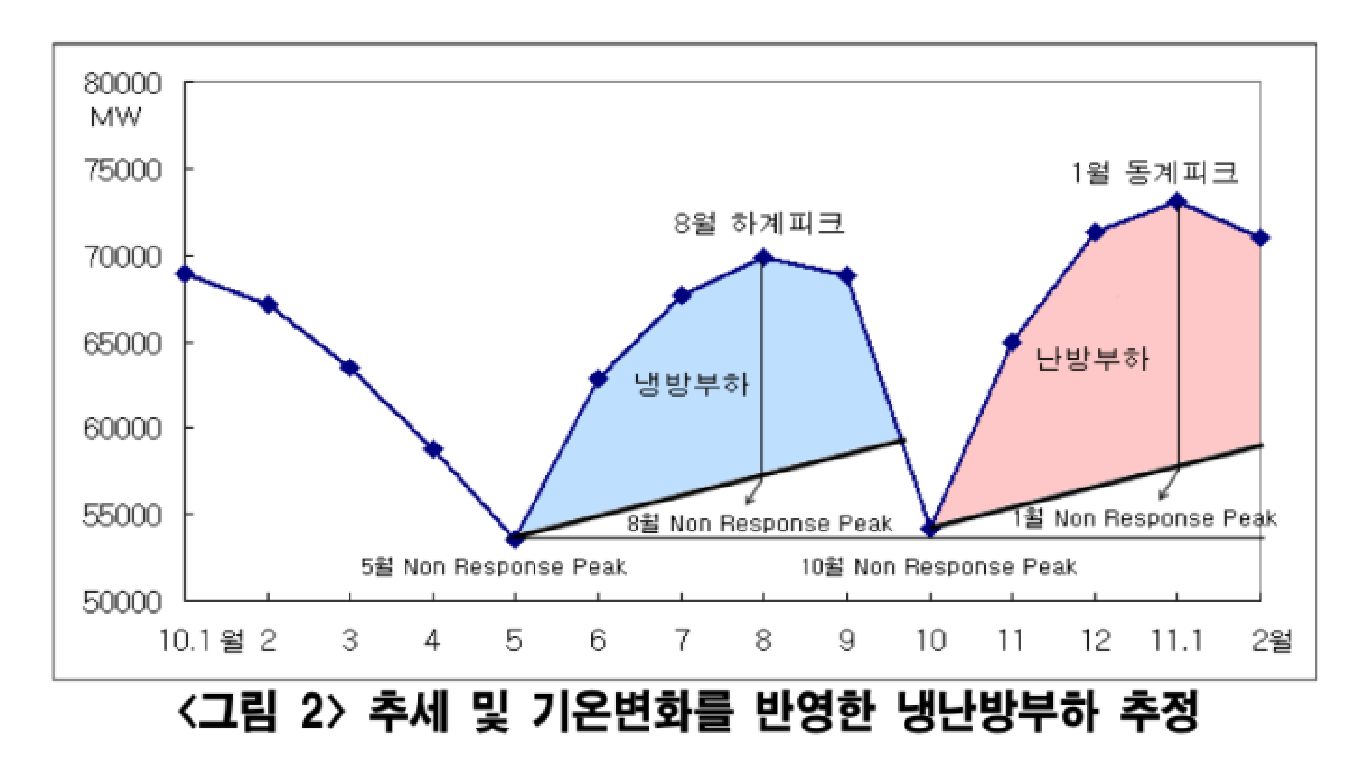

In [24]:
#3
plt.figure(figsize =(12, 12))

img1 = mpimg.imread('season.png')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(img1)

summer = np.logical_and((pd.DatetimeIndex(target_v2["date"]).month >= 6),\
                        (pd.DatetimeIndex(target_v2["date"]).month < 10))

# 난방기 기간 : 12월 ~ 3월
winter = np.logical_or((pd.DatetimeIndex(target_v2["date"]).month == 12),\
                        (pd.DatetimeIndex(target_v2["date"]).month <= 3))

# 환절기 : 4, 5 , 10, 11월
change_season = np.invert(np.logical_or(summer, winter))

target_v2["period"] = np.nan
period_winter = target_v2[winter]["period"].fillna("winter").reset_index(False)
period_summer = target_v2[summer]["period"].fillna("summer").reset_index(False)
period_cs = target_v2[change_season]["period"].fillna("cs").reset_index(False)
period = pd.concat([period_winter, period_summer, period_cs]).\
        sort_values(by=['index']).reset_index(drop=True)["period"]


target_v2["period"] = period


#### 4) GRNI 변수 추가를 위한 제주도 일일별 관광객 데이터/ 인구수 가져오기
- datetime의 데이터 타입을 datetime형태로 형변환
- tour에서 ' , ' 를 제외하고 int형태로 형변환

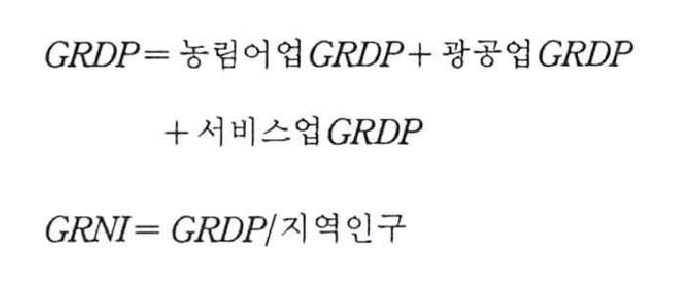

In [25]:
#남봉우, 송경빈, 김규호, 차준민 (2008). 다중회귀분석법을 이용한 지역전력수요예측 알고리즘. 조명전기설비학회 논문지, 22(2), 63-70 
# 지역전력수요예측 알고리즘을 개선하는 방향으로 로그 함수를 이용한 다중회귀분석을 제안한다.
img1 = mpimg.imread('local.png')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(img1)

In [26]:
# 4

# 관광객 추가
tour_df = pd.read_csv("tour_stat.csv")
tour_df["date"]= pd.to_datetime(tour_df["date"])
tour_df["tour"] =  tour_df["tour"].astype(int)
tour_df.tail()

# 제주도 인구 수 추가 
pop = pd.read_csv("kpi_pop.csv")[["month", "population"]]

#시간 해상도 월에서 일로 변경 
date = pd.date_range("2018-02-01", "2020-05-18", freq = "D")
date2 = date
date = pd.DataFrame(date)
date.rename(columns={0: 'date'}, inplace=True)
pop["month"] = date2[date2.day == 1]
pop.rename(columns={"month": 'date'}, inplace=True)
pop = pd.merge(date, pop, left_on='date', right_on='date', how='left')
pop = pd.DataFrame(pop)
pop = pop.interpolate(method='values')
pop["population"] = pop["population"].round(0)
target_v2 =pd.merge(target_v2,tour_df)
target_v2 =pd.merge(target_v2,pop)


#GRNI 변수 추가
target_v2["GRNI"] = np.log(target_v2["tour"]/target_v2["population"])

target_v2=target_v2[["date","max_temp","humid","period","body_temp","angry","GRNI","supply"]]
target_v2.tail()

,date,max_temp,humid,period,body_temp,angry,GRNI,supply
833,2020-05-14,24.2,0.562917,cs,18.6,61.003125,-3.358857,62.70
834,2020-05-15,26.4,0.915000,cs,19.8,61.565625,-3.411308,64.91
835,2020-05-16,21.3,0.965833,cs,17.4,61.016667,-3.372583,61.75
836,2020-05-17,21.0,0.916354,cs,17.0,61.044792,-3.314131,61.55
837,2020-05-18,28.4,0.921354,cs,19.1,61.588542,-3.330373,63.91


-

### 재밌는 데이터 체크

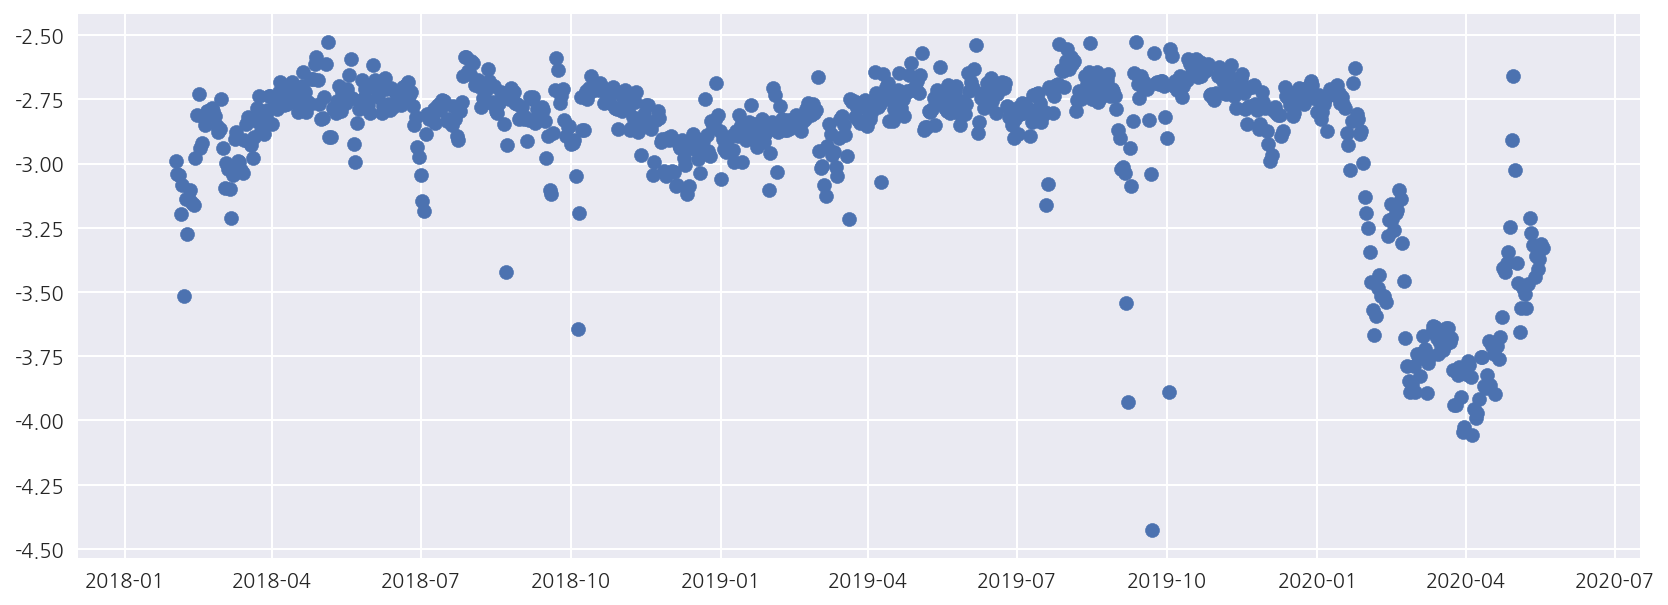

In [27]:
#코로나가 제주도 지역 발전에 영향!
plt.figure(figsize =(14, 5))
plt.scatter(target_v2["date"],target_v2["GRNI"])

-

# 최종 데이터 셋 확인

In [28]:
target_v2.columns

Index(['date', 'max_temp', 'humid', 'period', 'body_temp', 'angry', 'GRNI',
       'supply'],
      dtype='object')

In [29]:
target_v2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 0 to 837
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       838 non-null    datetime64[ns]
 1   max_temp   838 non-null    float64       
 2   humid      838 non-null    float64       
 3   period     838 non-null    object        
 4   body_temp  838 non-null    float64       
 5   angry      838 non-null    float64       
 6   GRNI       838 non-null    float64       
 7   supply     838 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 58.9+ KB


In [30]:
target_v2.isnull().sum()

date         0
max_temp     0
humid        0
period       0
body_temp    0
angry        0
GRNI         0
supply       0
dtype: int64

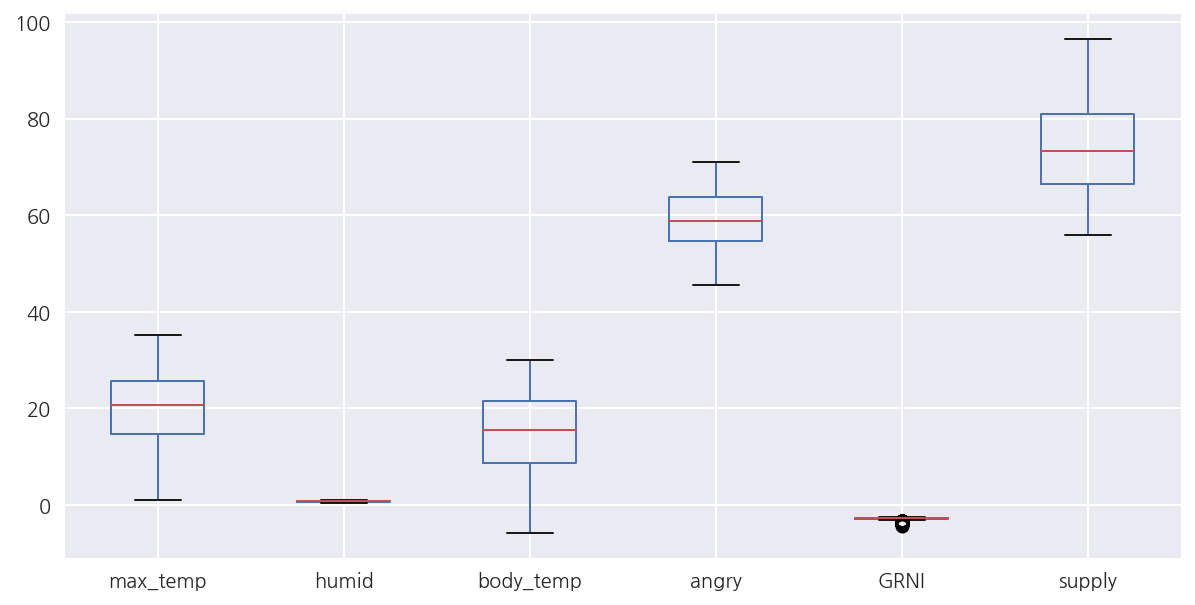

In [31]:
plt.figure(figsize =(10, 5))
target_v2.boxplot()

-

### OLS

# 기존 방식를 활용한 선형 방정식

In [32]:
formula = ("(supply)  ~ scale(max_temp)+scale(angry)+scale(body_temp)")

## 송경빈 외 3명 (2017) 다중회귀분석법을 이용한 전력량 예측알고리즘 한국 전기설비학회
기상변수로서 최고온도가 불쾌지수 체감온도 등이 계절과 무관하게 사용되었다

In [33]:
plt.figure(figsize =(15, 15))
img1 = mpimg.imread('temp.png')
plt.imshow(img1)

FileNotFoundError: [Errno 2] No such file or directory: 'temp.png'

<Figure size 1080x1080 with 0 Axes>

In [633]:
model = sm.OLS.from_formula(formula, data=target_v2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 supply   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     25.33
Date:                Wed, 08 Jul 2020   Prob (F-statistic):           1.09e-15
Time:                        15:02:35   Log-Likelihood:                -2972.9
No. Observations:                 838   AIC:                             5954.
Df Residuals:                     834   BIC:                             5973.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           74.2255      0.291  

-

## 체감 온도 와 최고 온도 다중 공산성

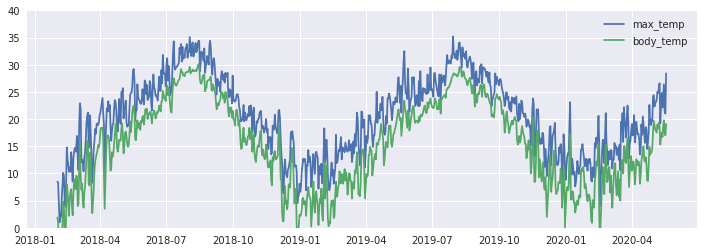

In [634]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target_v2.loc[:, 'max_temp'], label='max_temp')
plt.plot(target.loc[:, 'date'], target_v2.loc[:, 'body_temp'], label='body_temp',)
plt.ylim(0,40)
plt.legend()
plt.show()

In [635]:
y, X = dmatrices('supply ~ max_temp+body_temp+angry+GRNI', target_v2, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,236.356704,Intercept
1,27.967156,max_temp
2,28.158444,body_temp
3,1.004420,angry
4,1.097230,GRNI


In [636]:
y, X = dmatrices('supply ~ max_temp+angry+GRNI', target_v2, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,225.203465,Intercept
1,1.090139,max_temp
2,1.002027,angry
3,1.089982,GRNI


-

### 제안하는 방법(계절성을 고려한 기상변수로 전력예측)

In [637]:
formula1 = ("(supply)  ~ scale(max_temp)*C(period)+ I(scale(angry)*scale(max_temp)) +scale(GRNI)*C(period)")

In [638]:
model = sm.OLS.from_formula(formula1, data=target_v2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 supply   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     344.6
Date:                Wed, 08 Jul 2020   Prob (F-statistic):          5.59e-273
Time:                        15:02:35   Log-Likelihood:                -2357.0
No. Observations:                 838   AIC:                             4734.
Df Residuals:                     828   BIC:                             4781.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

#### 2)  모델 검증
교차 검증

장점 : 

1. 모든 데이터 셋을 평가에 활용할 수 있다.

  - 평가에 사용되는 데이터 편중을 막을 수 있다. 

  - 평가 결과에 따라 좀 더 일반화된 모델을 만들 수 있다. 
  

2. 모든 데이터 셋을 훈련에 활용할 수 있다.

  - 정확도를 향상시킬 수 있다.

  - 데이터 부족으로 인한 underfitting을 방지할 수 있다.


단점 : Iteration 횟수가 많기 때문에 모델 훈련/평가 시간이 오래 걸린다.


### 70의 데이터로 학습 30 프로 검증

In [639]:
target = target_v2
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(target, test_size=0.3, random_state=0)
df_train.shape, df_test.shape

((586, 8), (252, 8))

In [640]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(target)):
    df_train = target.iloc[idx_train]
    df_test = target.iloc[idx_test]
    
    model = sm.OLS.from_formula(formula1, data=target)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.supply - pred) ** 2).sum()
    tss = ((df_test.supply - df_test.supply.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.78929226, 검증 R2 = 0.76898554
학습 R2 = 0.78929226, 검증 R2 = 0.75066173
학습 R2 = 0.78929226, 검증 R2 = 0.82302084
학습 R2 = 0.78929226, 검증 R2 = 0.79165126
학습 R2 = 0.78929226, 검증 R2 = 0.79809410


### 학습된 데이터로 전력량 예측 결과 비교

In [641]:
model_real1 = sm.OLS.from_formula(formula, data=target_v2)
result_real1 = model_real1.fit()

model_real2 = sm.OLS.from_formula(formula1, data=target_v2)
result_real2 = model_real2.fit()


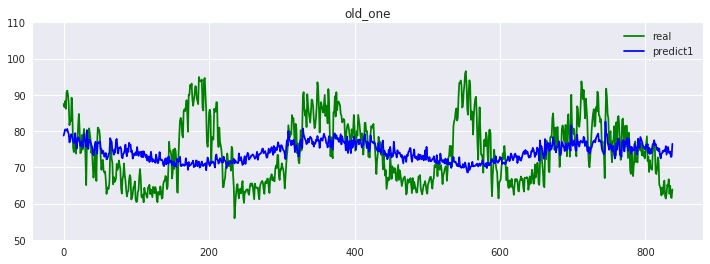

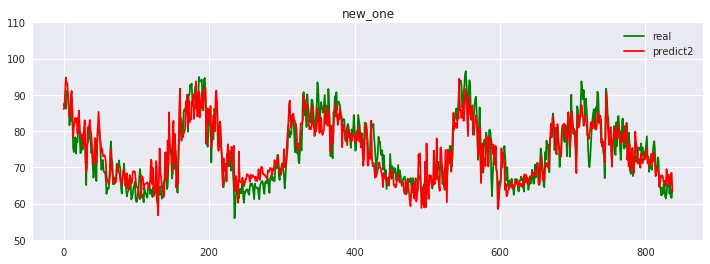

In [642]:
#기존의 선형회귀 방법
test = target_v2
ypred = result_real1.predict(test)
plt.figure(facecolor="1")
plt.plot(test["supply"],label='real', color='green')
plt.plot(ypred,label='predict1', color='blue')
plt.ylim(50,110)
plt.legend()
plt.title("old_one")
plt.show()

#우리조가 제안하는 방법
test2 = target
ypred = result_real2.predict(test2)
plt.figure(facecolor="1")
plt.plot(test2["supply"],label='real', color='green')
plt.plot(ypred,label='predict2',color='red')
plt.ylim(50,110)
plt.legend()
plt.title("new_one")
plt.show()


프로젝트를 마치며

단순 다중회귀 방법으로 현재 사용되는 인공신경망과 시계열 방법의 전력수요 예측에 성능에 미치지 못한점이 매우 아쉽다.

데이터를 수집할 때 시간 단위 데이터를 구하거나,GDP 데이터를 구해 왔으면 조금더 좋은 예측이 될수 있었을거 같다.


특수일을 고려한 퍼지선형 방법과 예측일 전의 전력량을 이용한 방법, 측정 데이터의 측정자 오차 보정 같은 것들을 한다면 좀더 

성능이 좋아질것 같다.

-

## 참고문헌



김기수,송경빈 / 송경빈한국조명·전기설비학회한국조명·전기설비학회 학술대회논문집 (2008.10) 225 - 228 

김기수, 류구현, 송경빈 /온도특성에 대한 데이터 정제를 이용한 제주도의 단기 전력수요예측 대한전기학회전기학회논문지 (2009.09) 1,695 - 1,699

구본희, 윤경하, 차준민 /기온특성을 고려한 제주지역 전력 수요 예측. 대한전기학회 학술대회 논문집 (2011.10) 250-253 

구본희, 차준민 / 기온변화특성을 이용한 제주계통 하절기 전력수요예측 대한전기학회대한전기학회 학술대회 논문집 (2012.05) 305 - 307

정희원, 구본희, 차준민/ 제주계통의 기온변화 민감도를 반영한 주말 전력수요예측 대한전기학회전기학회논문지 (2016.05) 718 - 723 (6 pages)

김혜민, 임병환, 유승훈/ 제주지역의 전력수요함수 추정 한국에너지학회한국에너지학회 학술발표회 (2017.04) 98-99 (역시 온도 고려)

배원식, 박정도, 송경빈 외 2명/ 제주도 단기 전력수요예측 개선을 위한 수요예측 오차분석 대한전기학회대한전기학회 학술대회 논문집 (2017.11)

김혜민, 김인겸, 이대근 외 2/ 기온변수를 이용한 제주지역의 전력수요함수 추정 명한국혁신학회한국혁신학회지13(2) 2018.05 105 - 120 (16 pages)

조세원, 박래준, 김경환 외 4명/ 제주도의 특수일 전력수요에 대한 기온 민감도 분석대한전기학회전기학회논문지67(8) 2018.08 1,019 - 1,023

조세원, 박래준, 송경빈/ 기상에 대한 동네예보를 활용한 제주도의 특수일 전력수요예측 알고리즘 한국조명·전기설비학회조명·전기설비학회논문지)(2019.06)

기상변수를 이용한 도서지역 전력수요 예측모형의 적합성에 관한 연구  김영은 , 조용성, 김경남 신재생에너지 13(2), 2017.6, 84-93(10 pages) 

남봉우, 송경빈, 김규호, 차준민 (2008). 다중회귀분석법을 이용한 지역전력수요예측 알고리즘. 조명전기설비학회 논문지, 22(2), 63-70 

박종인(한국전력거래소),  김광인(한국전력거래소) 대한전기학회대한전기학회 학술대회 논문집2011 대한전기학회 하계학술대회 논문집2011.07

Taylor.J.W (2010) triple seasonal methods for short-term electricity demand forecasting.

신이레, 윤상후 (2016). 전력수요예측을 위한 기상정보 활용성평가. 한국데이터정보과학회지 

송경빈 외 3명 (2017) 다중회귀분석법을 이용한 전력량 예측알고리즘 한국 전기설비학회

이근철, 한정희 (2017). 국내 일별 최대전력 수요예측에 관한 연구. 산업경제연구, 30(4), 1205-1218 

상호작용효과를 포함한 다중회귀분석에서 주효과의 검증에 대한 연구 이유재 한국경영학회경영학연구23(4)1994.11
